In [68]:
library(reticulate)
library(Seurat)
library(future)
library(dplyr)
library(ggpubr)
o <- function(w,h){
    options(repr.plot.width=w, repr.plot.height=h)
}

Loading required package: ggplot2



# load data from scanpy object

In [3]:
use_python("/home/chensijie/software/anaconda3/envs/r411py37/bin/python", required = T)

In [4]:
sc <- import("scanpy")
adata <- sc$read_h5ad("sorted_tcells_filtered.h5ad")
adata

AnnData object with n_obs × n_vars = 20553 × 20491
    obs: 'cid', 'cell_id', 'cell_type', 'cl_name', 'donor_age', 'donor_gender', 'donor_id', 'hcad_name', 'marker_gene', 'organ', 'original_name', 'region', 'sample_status', 'seq_tech', 'study_id', 'subregion', 'tissue_type', 'uHAF_name', 'user_id'
    var: 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'hvg', 'organ_colors', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [9]:
exprs <- t(as.matrix(adata$X))
colnames(exprs) <- adata$obs_names$to_list()
rownames(exprs) <- adata$var_names$to_list()

# Create the Seurat object
seurat <- CreateSeuratObject(exprs)

# Set the expression assay
seurat <- SetAssayData(seurat, "data", exprs)

# Add observation metadata
seurat <- AddMetaData(seurat, adata$obs)

# Add fetaure metadata
seurat[["RNA"]][["n_cells"]] <- adata$var["n_cells"]


Warning message:
“The following arguments are not used: row.names”


In [10]:
seurat

An object of class Seurat 
20491 features across 20553 samples within 1 assay 
Active assay: RNA (20491 features, 0 variable features)

# remove organs with fewer observations

In [53]:
cnt_by_organ = table(seurat$organ)
cnt_by_organ = cnt_by_organ[ cnt_by_organ >100]
kept_organ   = names(cnt_by_organ)
seurat <- subset(seurat, organ %in% kept_organ)

In [59]:
T.list <- SplitObject(seurat, split.by = "organ")

In [61]:
plan("sequential")
options(future.globals.maxSize = 4*1000 * 1024^2)

i=1

for (path in names(T.list)) {
    print(path)
    flush.console()
    Sys.sleep(0.01)
    
    plan("multiprocess", workers = 8)
    seu <- T.list[[path]]
    seu[["percent.mt"]] <- PercentageFeatureSet(seu, pattern = "^MT-")
    seu <- FindVariableFeatures(seu, selection.method = "vst", nfeatures=1000,verbose=F)
    seu <- ScaleData(seu, features = VariableFeatures(seu), verbose=F,block.size=1000, min.cells.to.block=200)
    seu <- RunPCA(seu, features = VariableFeatures(object = seu),npcs = 20,verbose=F)
    seu <- FindNeighbors(seu, dims = 1:20, verbose = F)
    seu <- FindClusters(seu, resolution = 0.7)
    T.list[[path]] <- seu
    plan("sequential")

    message( cat ("prep finished",i, "/", length(T.list))  )
    flush.console()
    Sys.sleep(0.01)
    i=i+1
    
}


[1] "Gallbladder"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 222
Number of edges: 10962

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4894
Number of communities: 3
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 1 / 20

[1] "Testis"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 921
Number of edges: 45657

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4304
Number of communities: 3
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 2 / 20

[1] "Spleen"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 410
Number of edges: 19185

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6561
Number of communities: 4
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 3 / 20

[1] "Lung"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5245
Number of edges: 198634

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8053
Number of communities: 11
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 4 / 20

[1] "Thymus"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1594
Number of edges: 74828

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6027
Number of communities: 5
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 5 / 20

[1] "Liver"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 891
Number of edges: 39774

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7461
Number of communities: 7
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 6 / 20

[1] "Muscle"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 235
Number of edges: 12272

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5793
Number of communities: 3
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 7 / 20

[1] "Colon"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 546
Number of edges: 28012

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6827
Number of communities: 4
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 8 / 20

[1] "Thyroid"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 467
Number of edges: 24772

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6221
Number of communities: 3
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 9 / 20

[1] "Eye"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 105
Number of edges: 3764

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4410
Number of communities: 2
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 10 / 20

[1] "Pancreas"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2233
Number of edges: 86263

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6842
Number of communities: 6
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 11 / 20

[1] "Kidney"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 243
Number of edges: 10543

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5004
Number of communities: 3
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 12 / 20

[1] "Blood"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3556
Number of edges: 159729

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8191
Number of communities: 11
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 13 / 20

[1] "Heart"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1160
Number of edges: 58960

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5916
Number of communities: 6
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 14 / 20

[1] "Jejunum"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 329
Number of edges: 18241

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4561
Number of communities: 3
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 15 / 20

[1] "Ureter"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 630
Number of edges: 41805

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.3907
Number of communities: 2
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 16 / 20

[1] "Prostate"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 241
Number of edges: 12765

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4481
Number of communities: 2
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 17 / 20

[1] "Stomach"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 256
Number of edges: 11778

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6288
Number of communities: 3
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 18 / 20

[1] "Intestine"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 575
Number of edges: 24329

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7555
Number of communities: 7
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 19 / 20

[1] "Rectum"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 313
Number of edges: 16154

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5074
Number of communities: 3
Elapsed time: 0 seconds


Warning message:
“UNRELIABLE VALUE: One of the ‘future.apply’ iterations (‘future_lapply-1’) unexpectedly generated random numbers without declaring so. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'future.seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'future.seed = NULL', or set option 'future.rng.onMisuse' to "ignore".”


prep finished 20 / 20

# make organ-cluster pseudo labels

In [62]:

for (i in 1:length(T.list)){
    seu <- T.list[[i]]
    seu@meta.data$cluster<- paste(seu@meta.data$organ, seu@meta.data$RNA_snn_res.0.7, sep="_")
    seu -> T.list[[i]]
}

In [63]:
# merge clusters
t.combined <- T.list[[1]]
for (i in 2:length(T.list)){
    t.combined <- merge(t.combined, T.list[[i]])
}

# a glance of the cell landscape

In [64]:
seu <- t.combined
seu <- FindVariableFeatures(seu, selection.method = "vst", nfeatures=1000,verbose=F)
seu <- ScaleData(seu, features = rownames(seu), verbose=F, block.size=1000, min.cells.to.block=200)
seu <- RunPCA(seu, features = VariableFeatures(object = seu), npcs = 50,verbose=F)
seu <- RunUMAP(seu, dims = 1:50, verbose = F, n.neighbors = 20L, min.dist = 0.2)
seu -> t.combined 

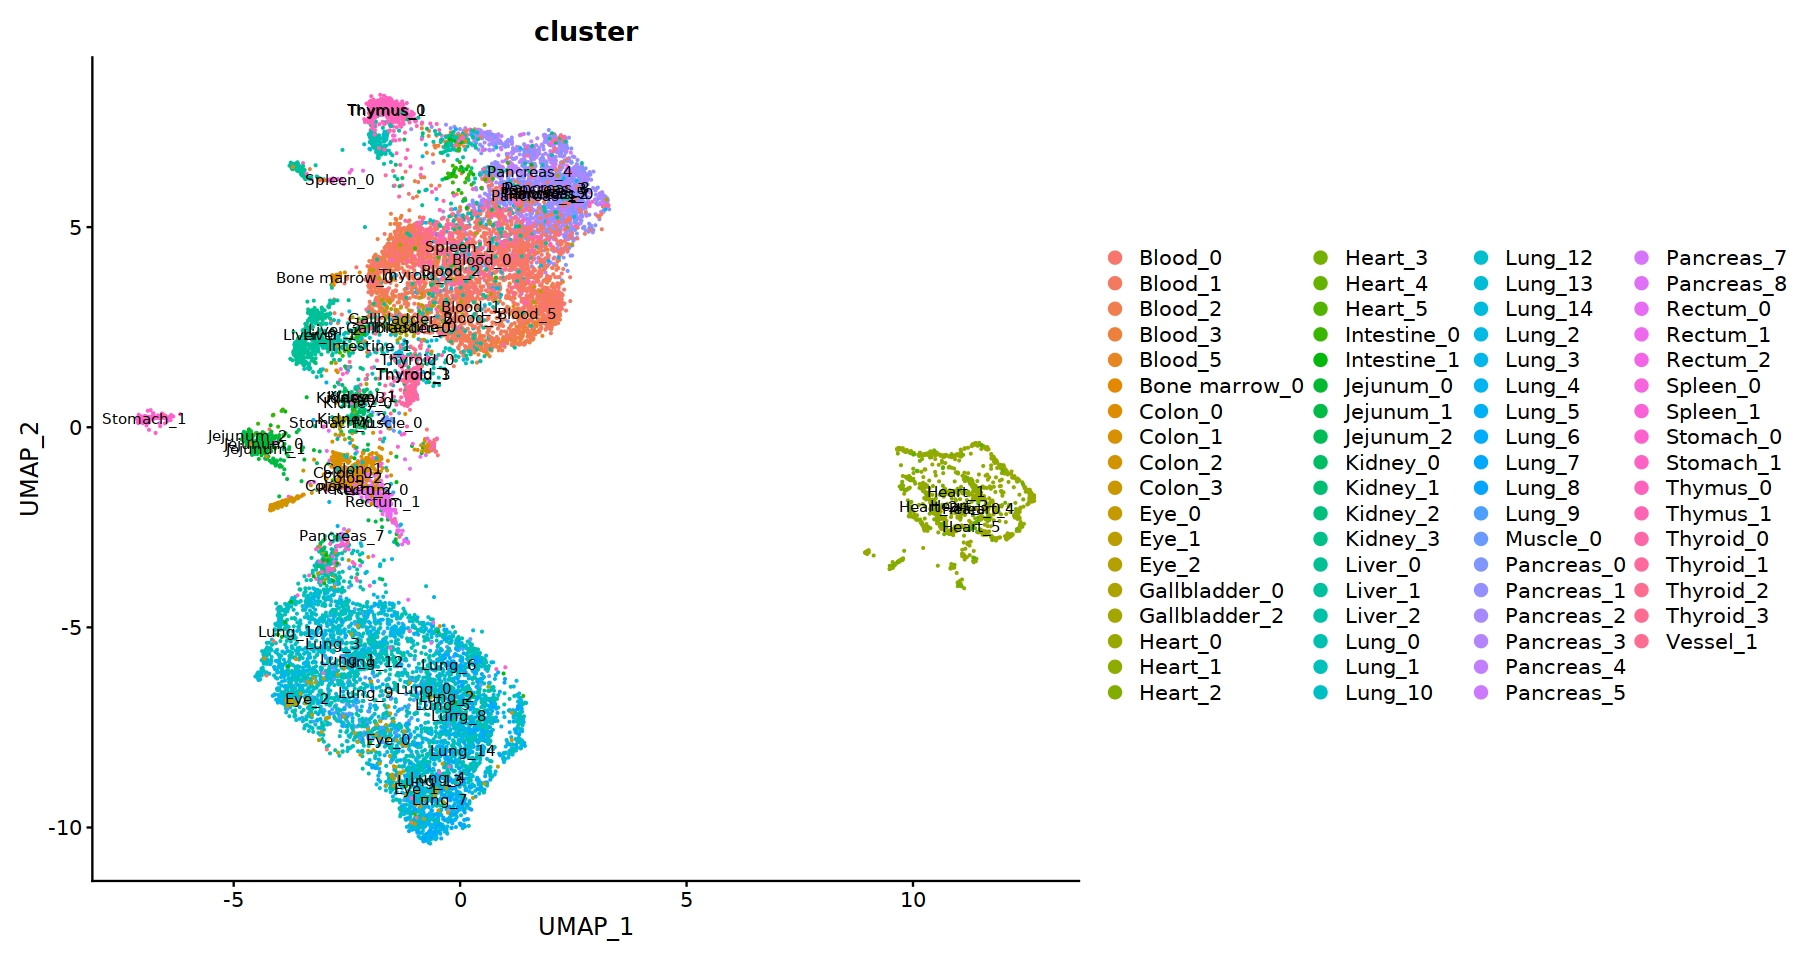

In [9]:
o(15,8)
DimPlot(t.combined, reduction = "umap", group.by="cluster", label=T, label.size=3.05)

# remove implausible clusters

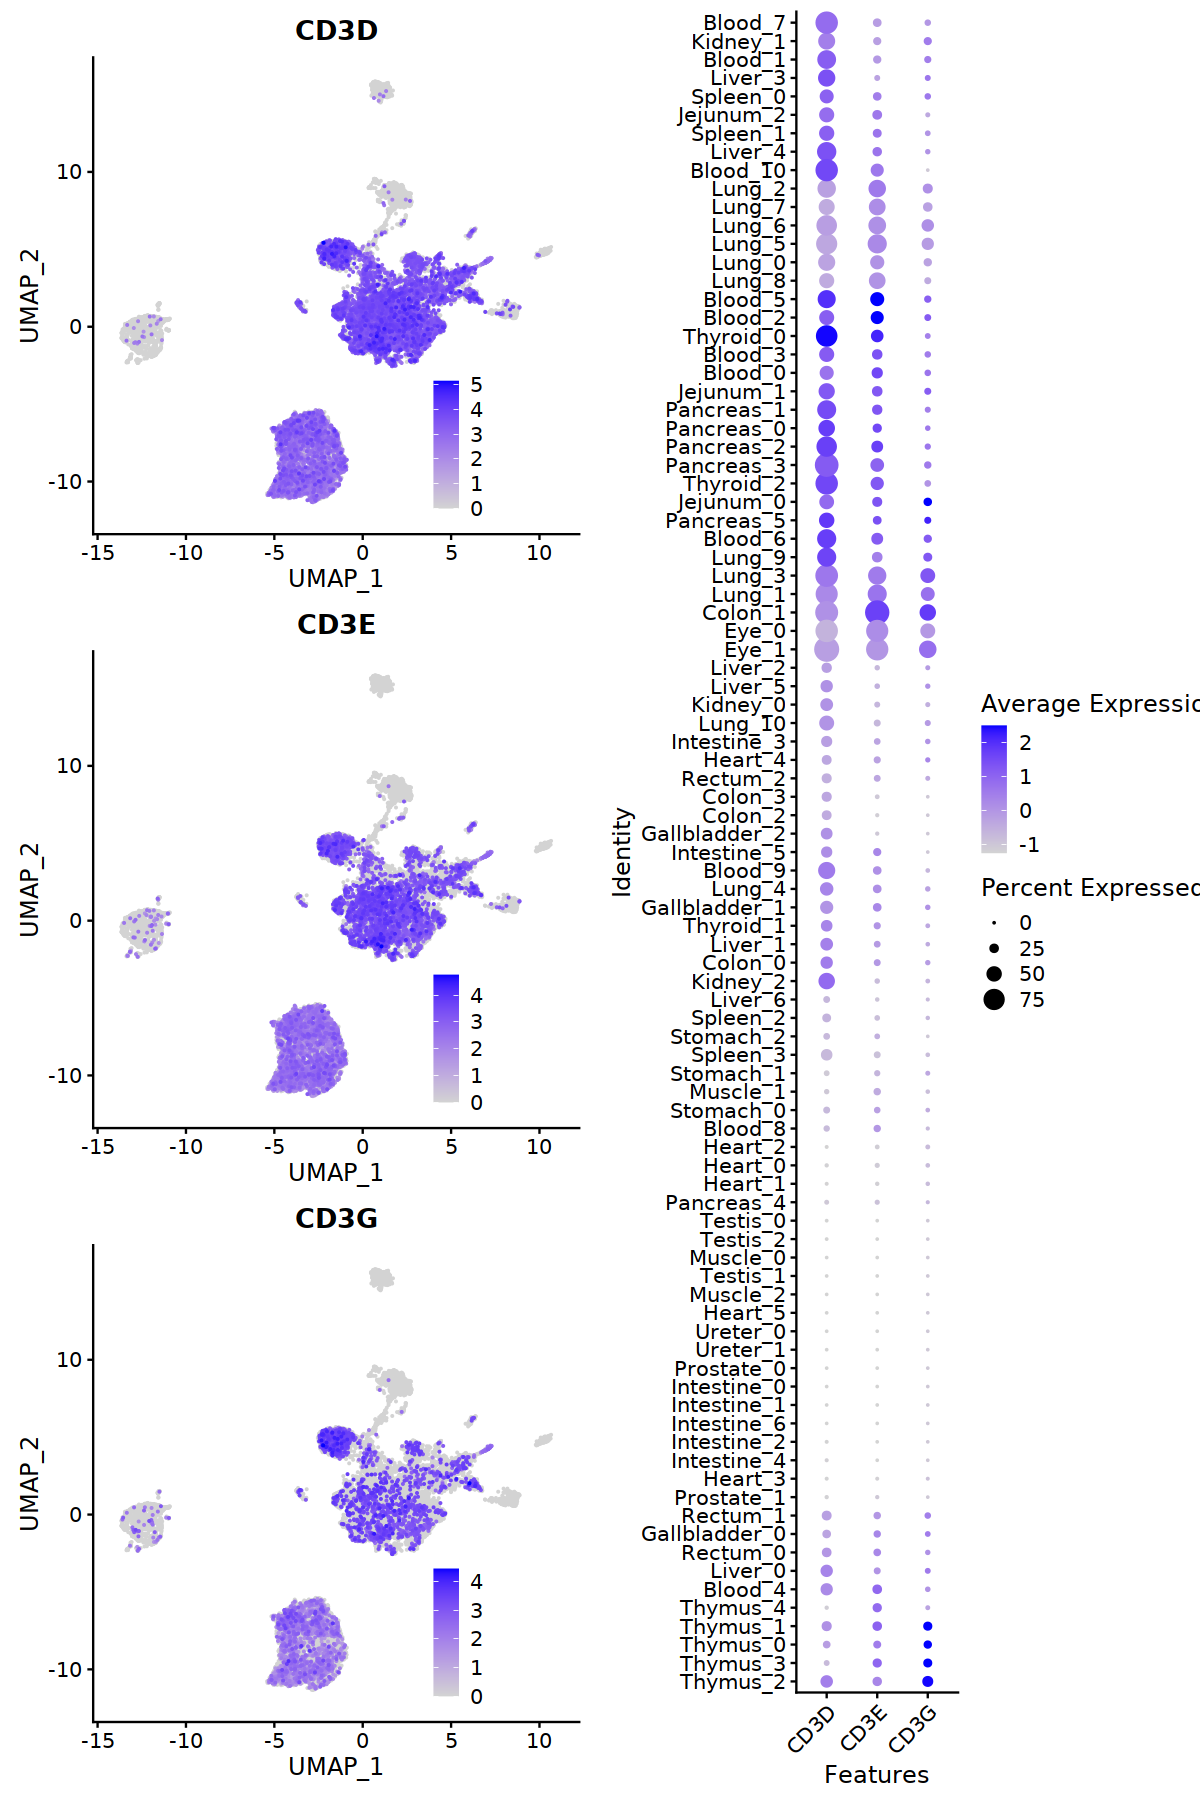

In [69]:
o(10,15)
Idents(t.combined)<-"cluster"
p1<-FeaturePlot(t.combined, features = c("CD3D","CD3E","CD3G"), order=T,ncol=1)&theme(legend.position=c(0.7,0.2))
p2<-DotPlot(t.combined, features = c("CD3D",'CD3E',"CD3G"  ),cluster.idents = T)+RotatedAxis()+theme(legend.position = "right")
ggarrange(p1,p2, ncol=2, nrow=1)


In [70]:
t.combined<-subset(t.combined, 
       cluster %in% c("Heart_0","Heart_1","Heart_2","Heart_3","Heart_4","Heart_5",
                     "Pancreas_4","Testis_0","Testis_1","Testis_2","Muscle_0",
                     "Muscle_2","Ureter_0","Ureter_1","Prostate_0","Prostate_1",
                     "Intestine_0","Intestine_1","Intestine_2","Intestine_4",
                     "Intestine_6")==FALSE)

In [71]:
seu <- t.combined
seu <- FindVariableFeatures(seu, selection.method = "vst", nfeatures=1000,verbose=F)
seu <- ScaleData(seu, features = rownames(seu), verbose=F, block.size=1000, min.cells.to.block=200)
seu <- RunPCA(seu, features = VariableFeatures(object = seu), npcs = 50,verbose=F)
seu <- RunUMAP(seu, dims = 1:50, verbose = F, n.neighbors = 20L, min.dist = 0.2)
seu -> t.combined 

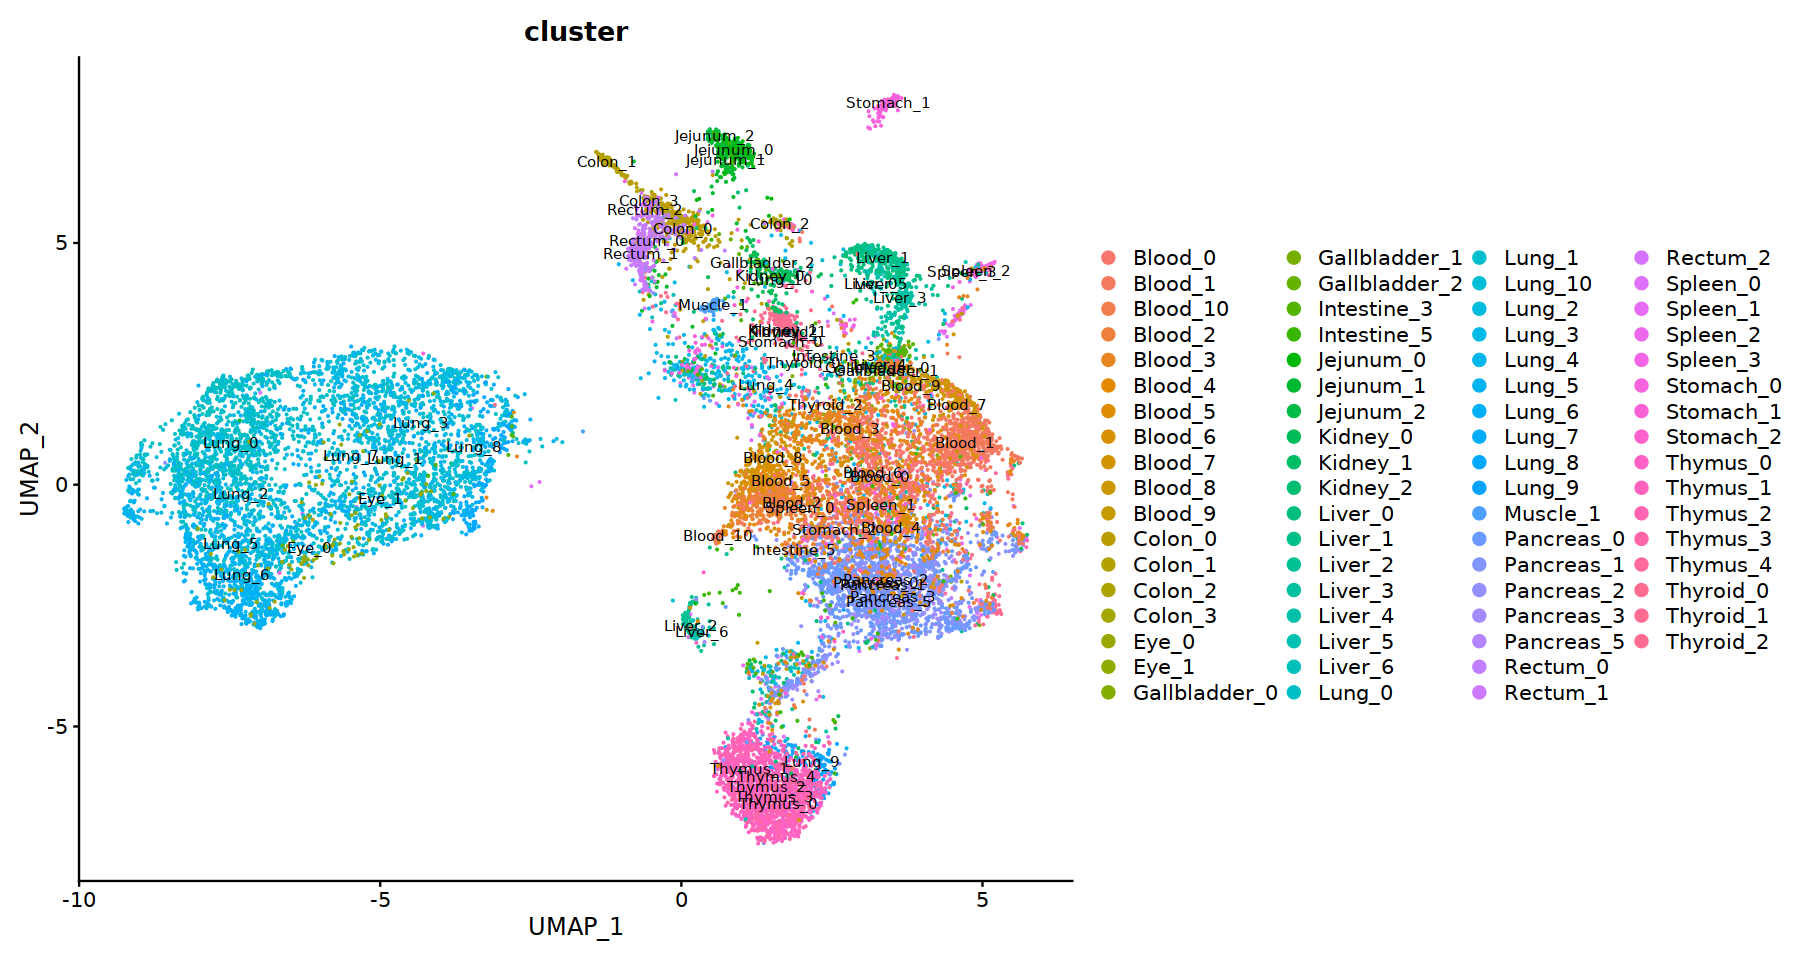

In [72]:
o(15,8)
DimPlot(t.combined, reduction = "umap", group.by="cluster", label=T, label.size=3.05)

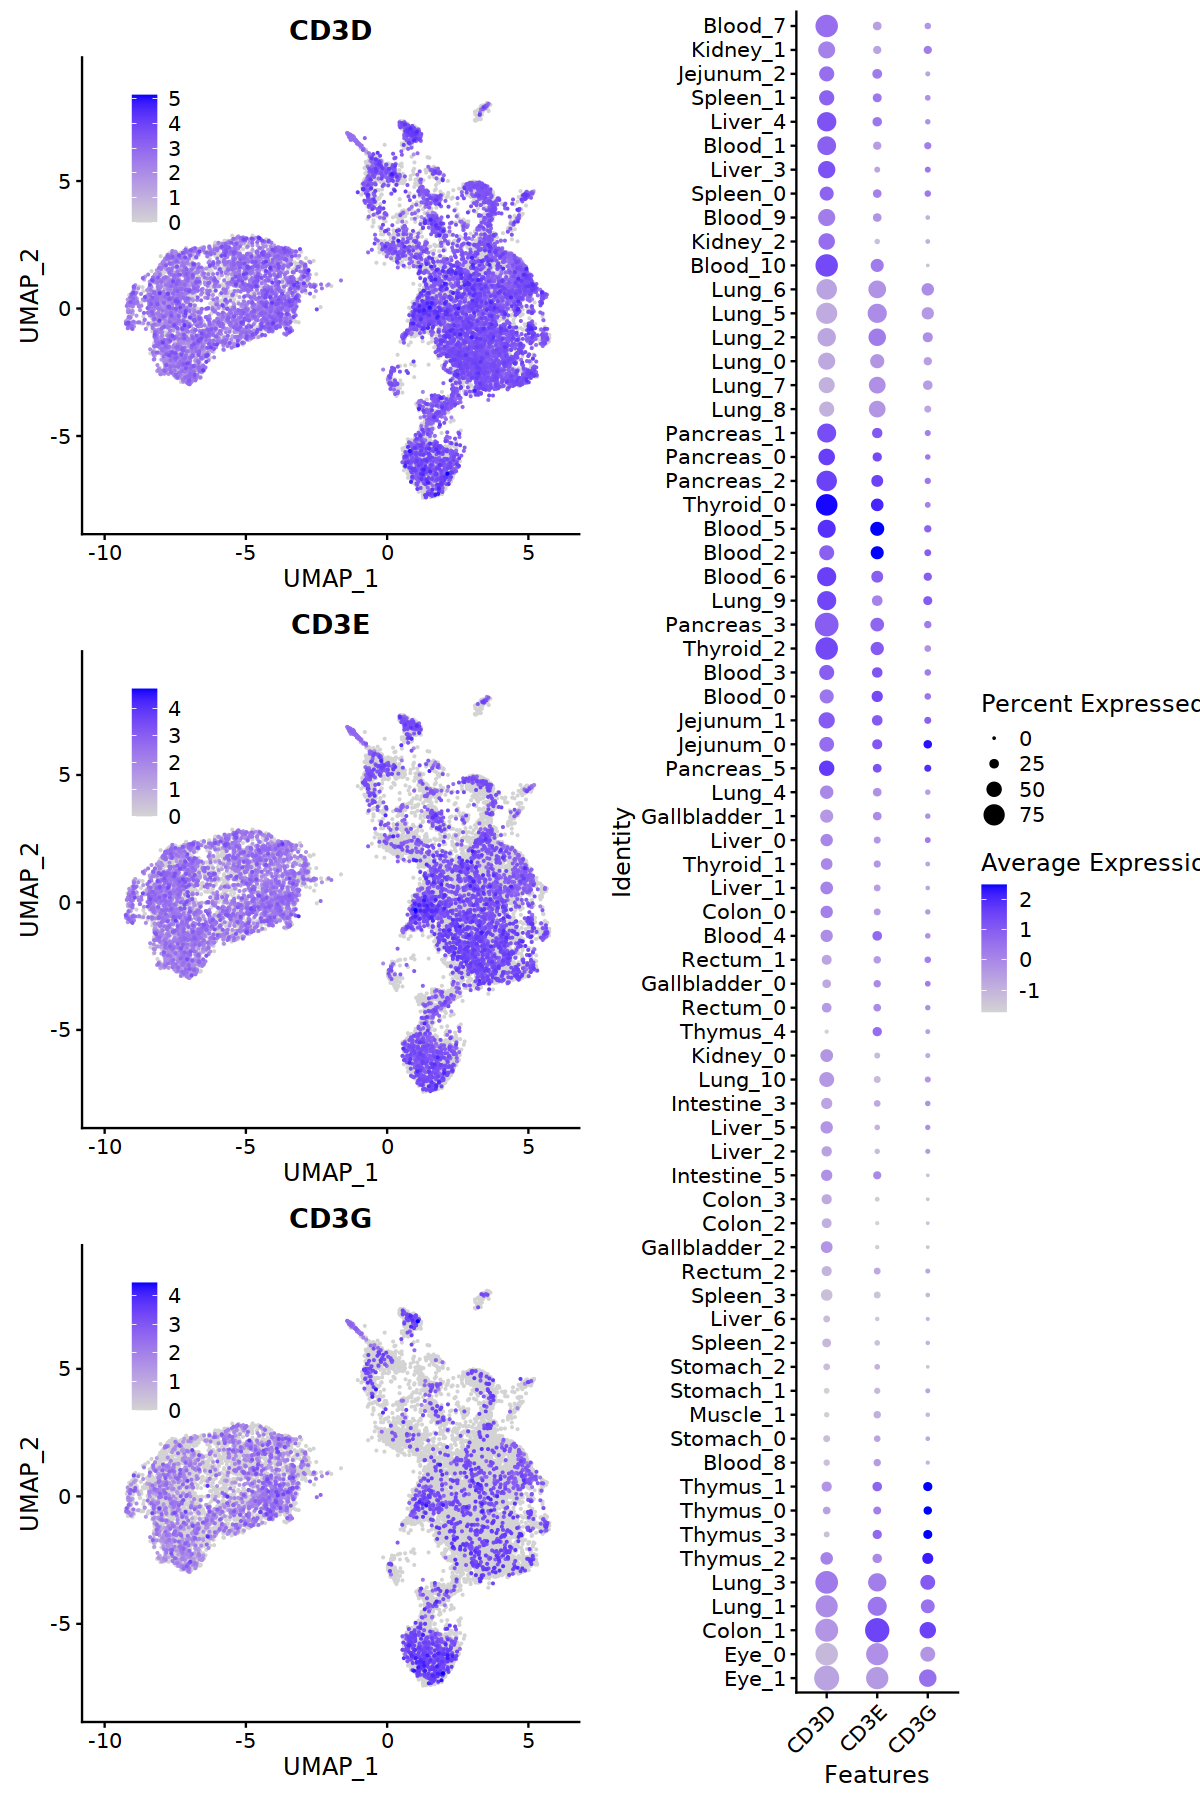

In [76]:
o(10,15)
Idents(t.combined)<-"cluster"
p1<-FeaturePlot(t.combined, features = c("CD3D","CD3E","CD3G"), order=T,ncol=1)&theme(legend.position=c(0.1,0.8))
p2<-DotPlot(t.combined, features = c("CD3D",'CD3E',"CD3G"  ),cluster.idents = T)+RotatedAxis()+theme(legend.position = "right")
ggarrange(p1,p2, ncol=2, nrow=1)


# Split CD4/CD8 subpopulation

In [447]:
# 1.1 收集表达矩阵
mat  = GetAssayData(t.combined, slot = "data", assay = "RNA")

# 1.2 把细胞按某种想要的顺序排好
ordered.cells <- rownames(t.combined@meta.data)

# 1.3 选择一列感兴趣的基因用于绘图
features.sel <-  unique(c("PTPRC","PECAM1","COL1A1","EPCAM", "ITGAX","ITGAM",
                          "TRAC","TRBC1",'TRBC2', "TRDC","TRGC1","TRGC2",
                          "CD79A","MS4A1","CD3D","CD3E","CD4","CD8A","CD8B","TBX21","TRAC","TRBC1",'TRBC2',
                          "TRDC","TRGC1","TRGC2",
                          "NCAM1","FCGR3A",
                          "GATA3","RORC","FOXP3","CTLA4","TCF7","LEF1",
           "IL2RA",'CD44','CD69',"SELL",'IL7R',"CD27","CD28","CCR7","KIT",
           "ITGAE","NKG7","IFNG","PRF1",'GZMA','GZMB',"GZMK","IL17A","IL23R",
            "CD40LG","TOX2","ICOS","PDCD1",
            "ISG15","IFIT1","IFIT2","IFIT3", "CXCR6","CCR6",
            'TNF', 'IL4'))

# 1.4 重新组织原始矩阵按行列
mat = as.matrix( mat[features.sel, ordered.cells] )


sub_grp
    1     2     3     4     5     6 
10803   642  1288  1097   618   195 

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



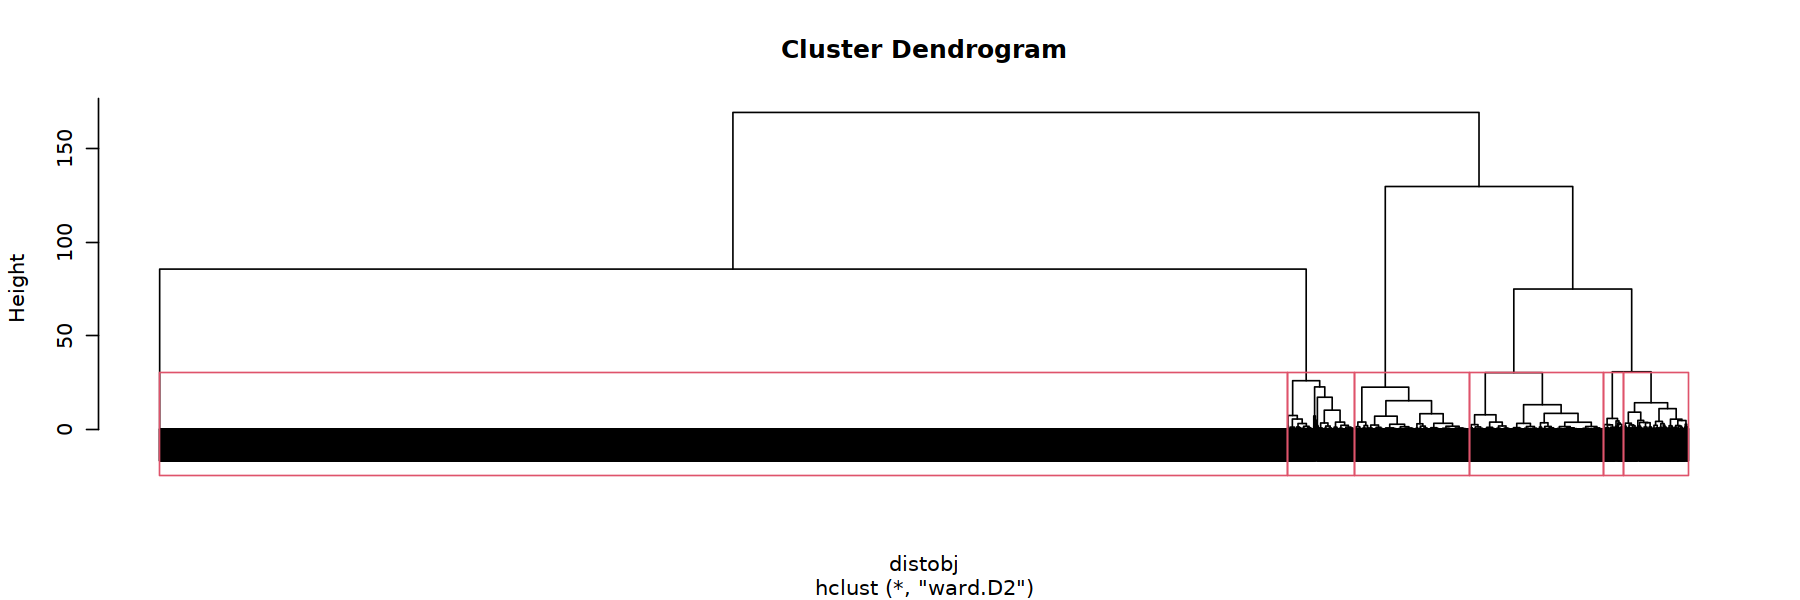

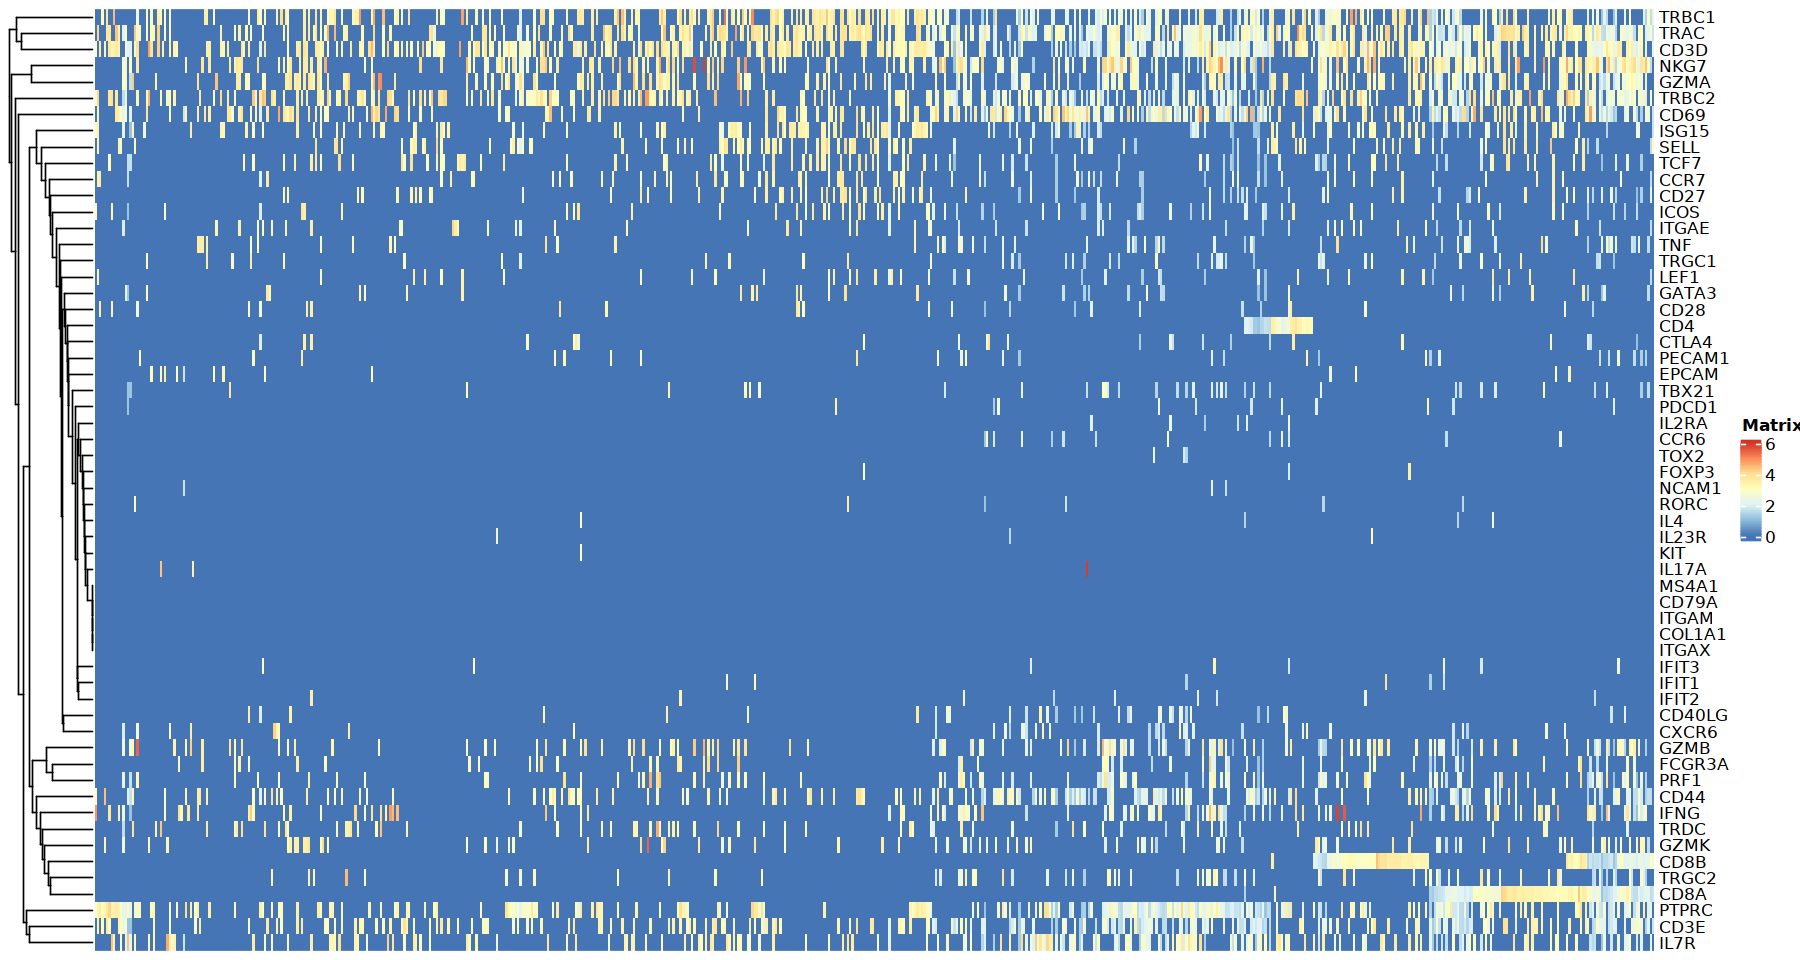

In [449]:
# 2.1 层次聚类
## 注意，mat是从Seurat来的feature-by-sample矩阵，应该转置成sample-by-feature矩阵；
## 此处选择一些基因做聚类，然后用另一些基因画zheng
distobj   <- dist(t(mat[c("CD4","CD8A","CD8B") , ]), method = "euclidean")
hclustobj <- hclust(distobj, method = "ward.D2" )

# 2.2 切隔树形成聚类
sub_grp <- cutree(hclustobj, k = 6) #参数k直接指定类别数,也可用参数h指定切割深度
# 打印各类里的细胞数看看
table(sub_grp) 
# 打印聚类树看看
options(repr.plot.width=15, repr.plot.height=5)
plot(hclustobj, cex = 0.1, label=F) #画🌲，label=F隐藏样本名，不然过密不美观
rect.hclust(hclustobj, k = 6) #画方框
# 按聚类树顺序画heatmap看看
library(pheatmap)
options(repr.plot.width=15, repr.plot.height=8)
pheatmap(mat[,hclustobj$order], cluster_rows = T, cluster_cols = F, 
         border_color=NA,
         show_colnames = F, use_raster=TRUE)

# 看看要是还行，就把层次聚类的结果标签弄进metadata去
t.combined@meta.data["subgroup"]<-as.character(sub_grp)


In [450]:
meta = t.combined@meta.data[ordered.cells,]


library(paletteer)  
cl_levels = unique(meta$subgroup)
blockcol = paletteer_d("ggsci::default_igv")[1:length(cl_levels)] %>% as.vector
names(blockcol) <-cl_levels


colann <- HeatmapAnnotation(
    cluster = meta$cluster,
    organ   = meta$organ,
    subgroup= meta$subgroup,
    col = list( subgroup = blockcol ),
    annotation_legend_param=list(
        cluster = list(nrow=5),
        organ = list(nrow=3),
        subgroup=list(nrow=1)
    )
)

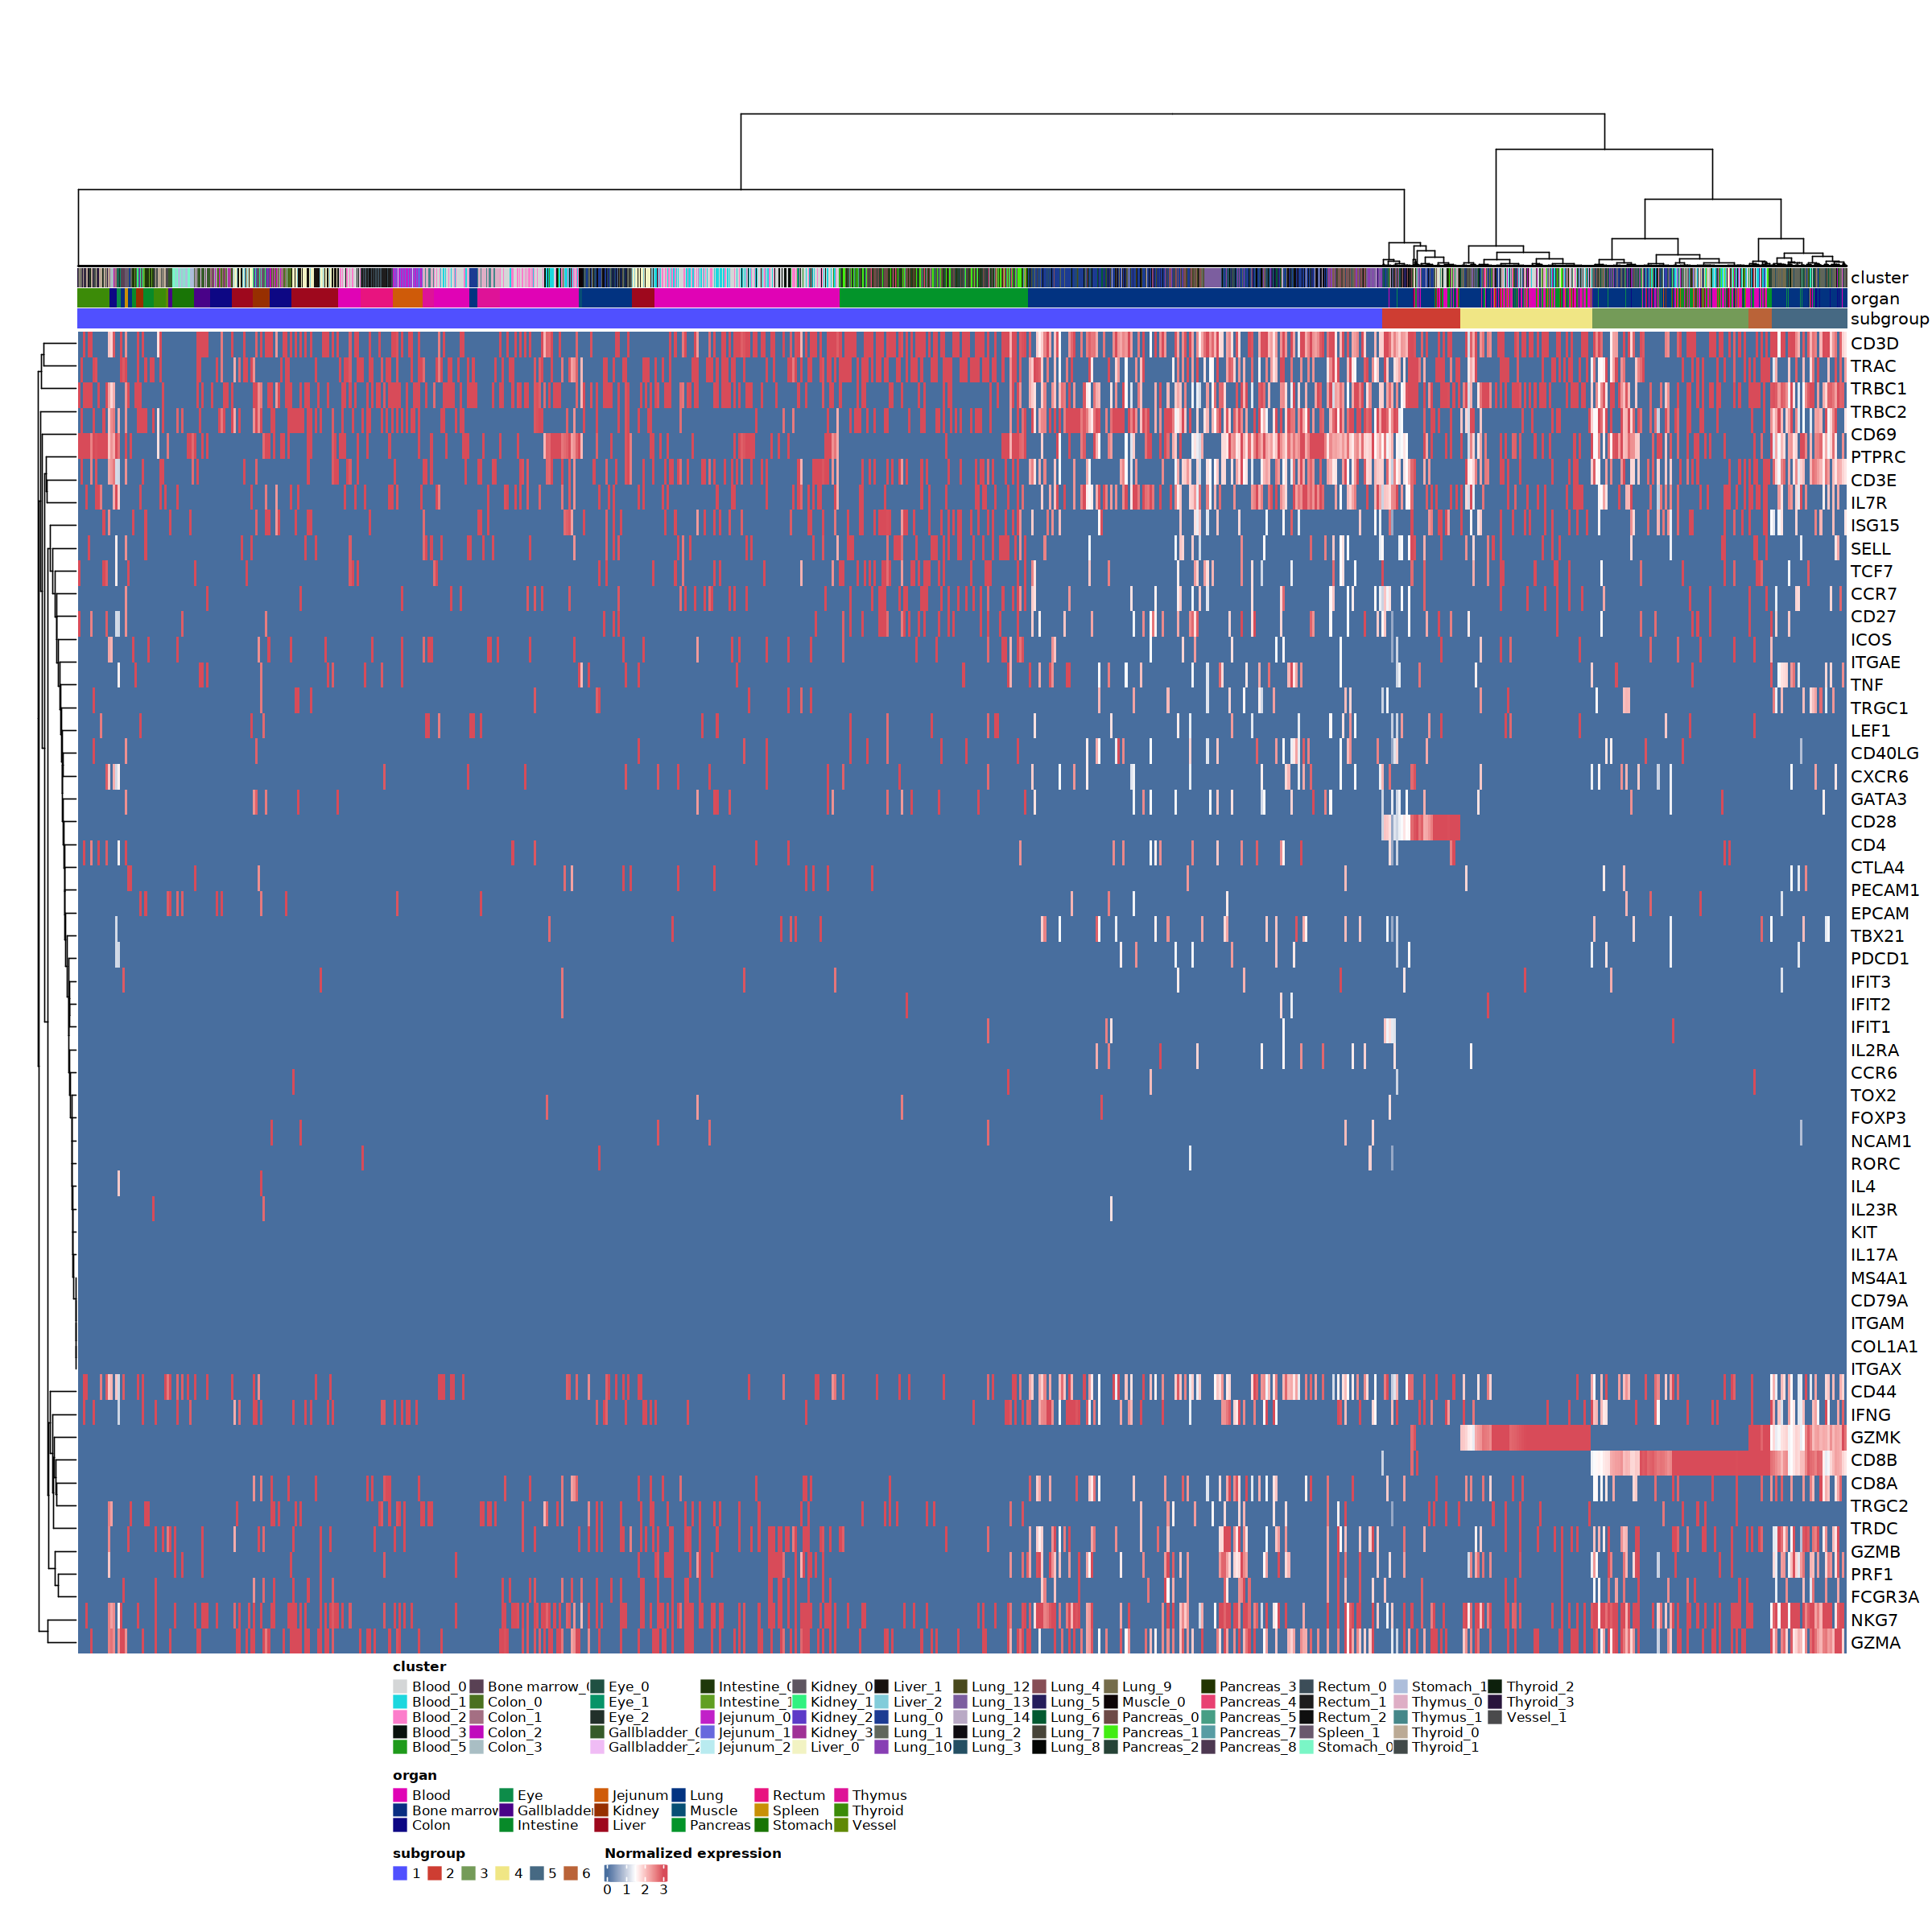

In [453]:
options(warn=-1)
options(repr.plot.width=20, repr.plot.height=20)
#cairo_pdf("XXXX.hm.pdf",width=15, height = 18)
draw(hm,
     padding = unit(c(10, 10, 30, 3), "mm"), #上右下左
     merge_legend = TRUE,
     heatmap_legend_side = "bottom", 
     annotation_legend_side = "bottom")
#dev.off()

In [454]:
options(warn=-1)
#options(repr.plot.width=20, repr.plot.height=20)
cairo_pdf("CD4CD8.hm.pdf",width=15, height = 18)
draw(hm,
     padding = unit(c(10, 10, 30, 3), "mm"), #上右下左
     merge_legend = TRUE,
     heatmap_legend_side = "bottom", 
     annotation_legend_side = "bottom")
dev.off()

png 
  2

In [456]:
Idents(t.combined)<-"subgroup"
t.combined <- RenameIdents(t.combined,
                           "1"="DN",
                           "2"="CD4+",
                           "3"="CD8+","4"="CD8+","5"="CD8+","6"="CD8+")
Idents(t.combined)->t.combined[["CD4CD8"]]

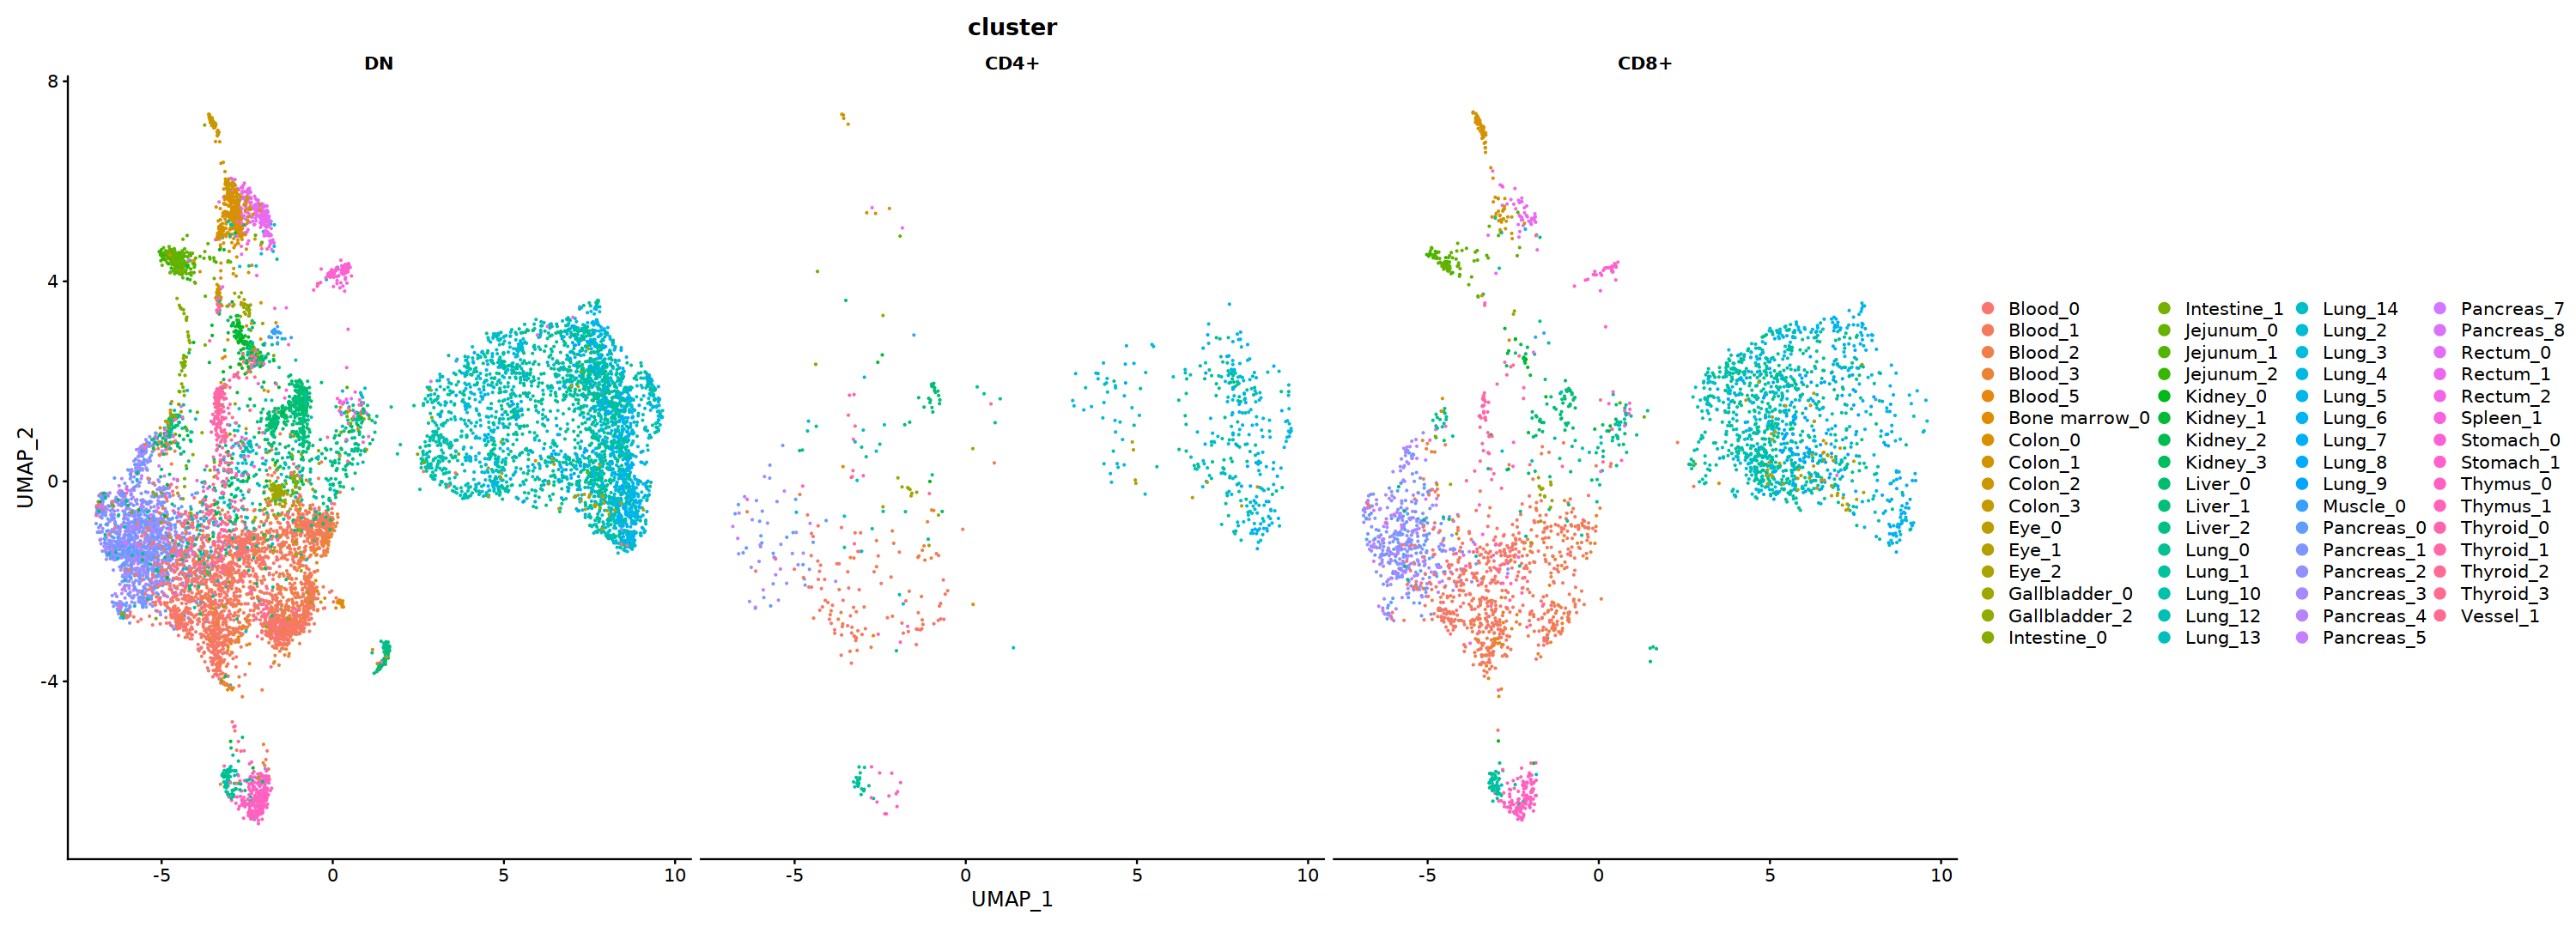

In [461]:
o(25,9)
DimPlot(t.combined, group.by="cluster", split.by="CD4CD8")

In [467]:
t.cd4 <- subset(t.combined, CD4CD8=="CD4+")
t.cd8 <- subset(t.combined, CD4CD8=="CD8+")
t.dn  <- subset(t.combined, CD4CD8=="DN")

In [79]:
save(t.cd4, file='t.cd4.rda')
save(t.cd4, file='t.cd8.rda')
save(t.cd4, file='t.dn.rda')

[1] 10